# Dataset

1. **inputs_weather_train.npy**: For each record, daily weather data - a total of 214 days spanning the crop growing season (defined April 1 through October 31). Daily weather records were compiled based on the nearest grid point from a gridded 30km product. Each day is represented by the following 7 weather variables - 
- Average Direct Normal Irradiance (ADNI)
- Average Precipitation (AP)
- Average Relative Humidity (ARH)
- Maximum Direct Normal Irradiance (MDNI)
- Maximum Surface Temperature (MaxSur)
- Minimum Surface Temperature (MinSur)
- Average Surface Temperature (AvgSur)

2. **inputs_others_train.npy**: Maturity Group (MG), Genotype ID, State, Year, and Location for each performance record.

3. **yield_train.npy**: Yearly crop yield value for each record.

We provide genotype clustering information in clusterID_genotype.npy. The file contains cluster ID for each of the 5839 genotypes. Participants may or may not use this information. We developed a completely connected pedigree for all lines with available parentage information, resulting in the formation of a 5839 x 5839 correlation matrix. 

**Feel free to use external datasets for the competition**. For the reproducibility of the results and prize money distribution, the top three teams must provide the open-source code and any external datasets used for the competition.

In [15]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from numpy.random import seed
from sklearn.preprocessing import StandardScaler

import graphviz
from datetime import date
import time
import pyreadr

import os

# Load data

In [16]:
Y = np.load('./Dataset_Competition/Training/yield_train.npy')
Weather_train = np.load('./Dataset_Competition/Training/inputs_weather_train.npy')
ClusterID = np.load('./Dataset_Competition/clusterID_genotype.npy')

# Extract MG
df_train = np.load('./Dataset_Competition/Training/inputs_others_train.npy')
df_train = pd.DataFrame(df_train, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))
MG = df_train['MG'].astype('category')
MG = MG.to_numpy()
MG = MG.reshape(-1,1)
MG = MG.astype(float).astype(int)

# Transform Genotype into ClusterID
Genotype = df_train['Genotype'].astype('category')
Genotype = Genotype.to_numpy()
Genotype = Genotype.astype(float).astype(int)
K = np.empty(len(Genotype))
for i in range(len(ClusterID)):
    K[Genotype==i] = ClusterID[i]
K = K.reshape(-1,1)
K = K.astype(int)

# Standardization prcess
scaler_x0 = StandardScaler().fit(Weather_train[:,:,0])
scaled_x0 = scaler_x0.transform(Weather_train[:,:,0])
scaler_x1 = StandardScaler().fit(Weather_train[:,:,1])
scaled_x1 = scaler_x0.transform(Weather_train[:,:,1])
scaler_x2 = StandardScaler().fit(Weather_train[:,:,2])
scaled_x2 = scaler_x0.transform(Weather_train[:,:,2])
scaler_x3 = StandardScaler().fit(Weather_train[:,:,3])
scaled_x3 = scaler_x0.transform(Weather_train[:,:,3])
scaler_x4 = StandardScaler().fit(Weather_train[:,:,4])
scaled_x4 = scaler_x0.transform(Weather_train[:,:,4])
scaler_x5 = StandardScaler().fit(Weather_train[:,:,5])
scaled_x5 = scaler_x0.transform(Weather_train[:,:,5])
scaler_x6 = StandardScaler().fit(Weather_train[:,:,6])
scaled_x6 = scaler_x0.transform(Weather_train[:,:,6])
X = np.dstack([scaled_x0, scaled_x1, scaled_x2, scaled_x3, scaled_x4, scaled_x5, scaled_x6])

# Transform into series data
print(X.shape)

X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))

print(X.shape)

# X = np.hstack((X, MG))
X = np.hstack((X, MG, K))

#####################################
# Load training and validation data #
#####################################
# 30% is val, 70% is training
seed(888)
X_train, X_val = train_test_split(X, test_size=0.8, shuffle=True, random_state=888)
X_val, X_test = train_test_split(X_val, test_size=0.5, shuffle=True, random_state=888)

Y_train, Y_val = train_test_split(Y, test_size=0.8, shuffle=True, random_state=888)
Y_val, Y_test = train_test_split(Y_val, test_size=0.5, shuffle=True, random_state=888)

##################
# Load test data #
##################
'''
Remind that values should be standardized
'''
df_test = np.load('./Dataset_Competition/Test Inputs/inputs_others_test.npy')
df_test = pd.DataFrame(df_test, columns=('MG', 'Genotype', 'State', 'Year', 'Site'))

(93028, 214, 7)
(93028, 1498)


In [17]:
# CHECK the number of genotypes, AFTER concatinating train and test
df = pd.concat([df_train, df_test], axis=0)
print(len(np.unique(df['Genotype'])))
np.unique(df['Genotype'])

5838


array(['1.0', '10.0', '100.0', ..., '997.0', '998.0', '999.0'],
      dtype=object)

# Parameter Tuning - CV
Repeated 5-fold CV for training dataset (Repeated for 2 times)

- First trial (2021-09-29): \
Without ClusterID\
lasso_alphas = np.linspace(0, 0.2, 21)
1039.650 seconds \
0.0


- Second trial (2021-09-29): \
With ClusterID\
lasso_alphas = np.linspace(0, 0.2, 21)
1214.520 seconds \
0.0


In [18]:
import multiprocessing
cpu_num = multiprocessing.cpu_count()
print(cpu_num)

36


In [19]:
from time import time
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# define the model
model = Lasso()

# define the evaluation procedure
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

lasso_alphas = np.linspace(0, 0.2, 21)
grid = dict()
grid['alpha'] = lasso_alphas

# define grid search
search = GridSearchCV(model, grid, n_jobs=cpu_num, cv=cv)

# record current time
start = time()

# perform search
search.fit(X_train,Y_train)

# record current time
end = time()

# report execution time
result = end - start
print('%.3f seconds' % result)

c:\users\takashi tanaka\venv\lib\site-packages\sklearn\model_selection\_search.py:765: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
c:\users\takashi tanaka\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


1214.520 seconds


c:\users\takashi tanaka\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591353.3205215447, tolerance: 476.1884486306908
  positive)


In [20]:
# Best parameter
search.best_params_

{'alpha': 0.0}

In [21]:
# All scores
search.set_params


<bound method BaseEstimator.set_params of GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
             estimator=Lasso(), n_jobs=36,
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])})>

# Retrain the model using the optimized parameters

In [22]:
model = Lasso(alpha=0.0)
model.fit(X_train,Y_train)

c:\users\takashi tanaka\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
c:\users\takashi tanaka\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\takashi tanaka\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 591353.3205215447, tolerance: 476.1884486306908
  positive)


Lasso(alpha=0.0)

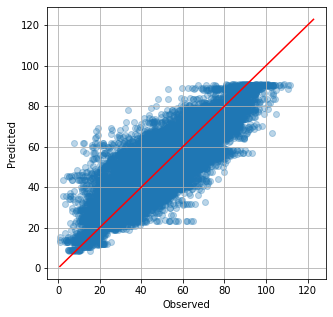

Test RMSE: 8.29
Test MAE: 6.24
Test R2: 0.728


In [23]:
pred_test = model.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(Y_test, pred_test, alpha=0.3) 
plt.xlabel('Observed') 
plt.ylabel('Predicted')
x = np.arange(0.9*min(Y_test).item(), 1.1*max(Y_test).item(), 0.1)
y = x
plt.plot(x, y,"r-")   
plt.grid()
plt.show()

print("Test RMSE: %.2f" % (np.sqrt(mean_squared_error(Y_test, pred_test))))
print("Test MAE: %.2f" % (mean_absolute_error(Y_test, pred_test)))
print("Test R2: %.3f" % (r2_score(Y_test, pred_test)))